In [92]:
import numpy as np
import os
import pandas as pd
from datetime import timedelta
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [93]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [94]:
def remove_anomaly_low(data):
    new_data=data.copy()
    new_data=new_data.sort_values(by='daily_consumption')
    new_data = new_data.reset_index(drop=True)
    [a,l]=new_data.shape
    a1=a-20
    new_data=new_data.head(a1)
    print('size of anomaly removed data:')
    print(new_data.shape)
    return new_data

In [95]:
def get_filename_list(my_dir):
    import os
    a=[]
    for root, dirs, files in os.walk(my_dir):
        for name in files:
            if name.endswith((".csv")):
                new_name=os.path.join(root,name)
                #new_name=dirs+name
                a.append(new_name)
    return a

In [96]:
def process_dur(data):
    time_difference = pd.to_datetime(data['set_T'],unit='s')-pd.to_datetime(data['rise_T'],unit='s')
    time_difference_in_minutes = time_difference / timedelta(minutes=1)
    data['dur']=time_difference_in_minutes
    return data


In [97]:
def preprocess_xgb(data):
    new_data=data.copy()
    new_data['month'] = new_data.StartTime.str[5:7]
    month_id=['01','02','03','04','05','06','07','08','09','10','11','12']
    month_name=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    sLength = len(new_data.Lse_header)
    new_data['month_name'] = pd.Series(np.random.randn(sLength), index=new_data.index)
    for k in range(0,12):
        new_data.month_name[new_data.month==month_id[k]]=month_name[k]
    new_data=new_data.sort_values(by='StartTime')
    return new_data

In [98]:
def split_test_train(new_data,month):
    rot_month_id=['01','02','03','04','05','06','07','08','09','10','11','12']
    month_col=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    m_id=month_col.index(month)
    rot_month_name=['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar']
    i=m_id+3
    data_1=new_data[new_data['month_name']==rot_month_name[i-1]]
    data_2=new_data[new_data['month_name']==rot_month_name[i-2]]
    data_3=new_data[new_data['month_name']==rot_month_name[i-3]]
    data1=new_data[new_data['month_name']==rot_month_name[i+1]]
    data2=new_data[new_data['month_name']==rot_month_name[i+2]]
    data3=new_data[new_data['month_name']==rot_month_name[i+3]]
    train_frame=[data_3,data_2,data_1,data1,data2,data3]
    train=pd.concat(train_frame,ignore_index=False)
    train = train.reset_index(drop=True)

    test=new_data[new_data['month_name']==rot_month_name[i]]
    #test_frame=[test_data]
    #test=pd.concat(test_frame,ignore_index=True)
    test = test.reset_index(drop=True)


    print('test dimension:')
    print(len(test['High']))
    print('train dimension:')
    print(len(train['High']))
    return train,test

In [99]:
def split_test_train_11(new_data,month):
    month_col=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    m_id=month_col.index(month)
    i=m_id
    train=new_data[new_data['month_name']!=month_col[i]]
    train = train.reset_index(drop=True)

    test=new_data[new_data['month_name']==month_col[i]]
    test = test.reset_index(drop=True)

    print('test dimension:')
    print(len(test['High']))
    print('train dimension:')
    print(len(train['High']))
    return train,test

In [100]:
def process_train_test(train,test):
    Ytrain=train['daily_consumption']
    Xtrain=train.drop(['daily_consumption'], axis=1)
    Xtrain=Xtrain.drop(['TDSPName','ServiceZip','LseHeaderID','StartTime','StopTime','Lse_header','month','month_name','rise_T','set_T'], axis=1)
    Ytest=test['daily_consumption']
    Xtest=test.drop(['daily_consumption'], axis=1)
    Xtest=Xtest.drop(['TDSPName','ServiceZip','LseHeaderID','StartTime','StopTime','Lse_header','month','month_name','rise_T','set_T'], axis=1)
    return Xtrain,Xtest,Ytrain,Ytest

In [101]:
def run_classifier(train,test):
    import xgboost as xgb
    Ytrain=train['daily_consumption']
    Xtrain=train.drop(['daily_consumption'], axis=1)
    Xtrain=Xtrain.drop(['TDSPName','ServiceZip','LseHeaderID','StartTime','StopTime','Lse_header','month','month_name','rise_T','set_T'], axis=1)
    Ytest=test['daily_consumption']
    Xtest=test.drop(['daily_consumption'], axis=1)
    Xtest=Xtest.drop(['TDSPName','ServiceZip','LseHeaderID','StartTime','StopTime','Lse_header','month','month_name','rise_T','set_T'], axis=1)
    
    dtrain = xgb.DMatrix(Xtrain,label=Ytrain)
    dtest = xgb.DMatrix(Xtest,label=Ytest)
    #param = {'max_depth':21, 'eta':0.07, 'nthread' : 8,'silent':1, 'objective':'reg:linear' ,'gamma' : 0}
    param = {'max_depth':21, 'eta':0.07, 'nthread' : 8,'silent':1, 'objective':'reg:linear' ,'gamma' : 0, 'nthread' :8, 'min_child_weight': 8, 'subsample': 0.95, 'colsample_bytree': 0.7, 'alpha': 0,'lambda': 0}

    num_round = 100
    bst = xgb.train(param, dtrain, num_round)
    # make prediction
    preds = bst.predict(dtest)
    
    return preds,Ytest

In [102]:
def run_classifier_grid(train,test):
    Ytrain=train['daily_consumption']
    Xtrain=train.drop(['daily_consumption'], axis=1)
    Xtrain=Xtrain.drop(['TDSPName','ServiceZip','LseHeaderID','StartTime','StopTime','Lse_header','month','month_name','rise_T','set_T'], axis=1)
    Ytest=test['daily_consumption']
    Xtest=test.drop(['daily_consumption'], axis=1)
    Xtest=Xtest.drop(['TDSPName','ServiceZip','LseHeaderID','StartTime','StopTime','Lse_header','month','month_name','rise_T','set_T'], axis=1)

    import xgboost as xgb
    objective = "reg:linear"
    seed = 100
    n_estimators = 100
    learning_rate = 0.02
    gamma = 0
    subsample = 0.95
    colsample_bytree = 0.7
    reg_alpha = 0
    reg_lambda = 0
    silent = False

    parameters = {}
    parameters['objective'] = objective
    parameters['seed'] = seed
    parameters['n_estimators'] = n_estimators
    parameters['learning_rate'] = learning_rate
    parameters['gamma'] = gamma
    parameters['colsample_bytree'] = colsample_bytree
    parameters['reg_alpha'] = reg_alpha
    parameters['reg_lambda'] = reg_lambda
    parameters['silent'] = silent

    scores = []

    cv_params = {
                 'min_child_weight': [5, 6, 7, 8, 9, 10],
                 'max_depth': [16, 17, 21, 27, 31, 41]
                }

    gbm = GridSearchCV(xgb.XGBRegressor(
                                            objective = objective,
                                            seed = seed,
                                            n_estimators = n_estimators,
                                            learning_rate = learning_rate,
                                            gamma = gamma,
                                            subsample = subsample,
                                            colsample_bytree = colsample_bytree,
                                            reg_alpha = reg_alpha,
                                            reg_lambda = reg_lambda,
                                            silent = silent

                                        ),

                        param_grid = cv_params,
                        iid = False,
                        scoring = "neg_mean_squared_error",
                        cv = 5,
                        verbose = True
    )

    gbm.fit(Xtrain,Ytrain)
    print("Best parameters %s" %gbm.best_params_)
    print("Best score %s" %gbm.best_score_)

    max_depth = gbm.best_params_['max_depth']
    min_child_weight = gbm.best_params_['min_child_weight']
    parameters['max_depth'] = max_depth
    parameters['min_child_weight'] = min_child_weight
    scores.append(gbm.best_score_)

    cv_params = {'max_depth': [max_depth-1, max_depth, max_depth+1], 
                 'min_child_weight': [min_child_weight-1, min_child_weight-0.5, min_child_weight, min_child_weight+0.5, min_child_weight+1]
                }

    gbm = GridSearchCV(xgb.XGBRegressor(
                                            objective = objective,
                                            seed = seed,
                                            n_estimators = n_estimators,
                                            learning_rate = learning_rate,
                                            gamma = gamma,
                                            subsample = subsample,
                                            colsample_bytree = colsample_bytree,
                                            reg_alpha = reg_alpha,
                                            reg_lambda = reg_lambda,
                                            silent = silent

                                        ),

                        param_grid = cv_params,
                        iid = False,
                        scoring = "neg_mean_squared_error",
                        cv = 5,
                        verbose = True
    )

    gbm.fit(Xtrain,Ytrain)
    print("Best parameters %s" %gbm.best_params_)
    print("Best score %s" %gbm.best_score_)

    max_depth = gbm.best_params_['max_depth']
    min_child_weight = gbm.best_params_['min_child_weight']
    parameters['max_depth'] = max_depth
    parameters['min_child_weight'] = min_child_weight
    scores.append(gbm.best_score_)

    cv_params = {'gamma': [i/10.0 for i in range(1,10,2)]}

    gbm = GridSearchCV(xgb.XGBRegressor(
                                            objective = objective,
                                            seed = seed,
                                            n_estimators = n_estimators,
                                            max_depth = max_depth,
                                            min_child_weight = min_child_weight,
                                            learning_rate = learning_rate,
                                            subsample = subsample,
                                            colsample_bytree = colsample_bytree,
                                            reg_alpha = reg_alpha,
                                            reg_lambda = reg_lambda,
                                            silent = silent

                                        ),

                        param_grid = cv_params,
                        iid = False,
                        scoring = "neg_mean_squared_error",
                        cv = 5,
                        verbose = True
    )

    gbm.fit(Xtrain,Ytrain)
    print("Best parameters %s" %gbm.best_params_)
    print("Best score %s" %gbm.best_score_)

    gamma = gbm.best_params_['gamma']
    parameters['gamma'] = gamma
    scores.append(gbm.best_score_)

    cv_params = {'subsample': [i/10.0 for i in range(6,11)],
                 'colsample_bytree': [i/10.0 for i in range(6,11)]
                }

    gbm = GridSearchCV(xgb.XGBRegressor(
                                            objective = objective,
                                            seed = seed,
                                            n_estimators = n_estimators,
                                            max_depth = max_depth,
                                            min_child_weight = min_child_weight,
                                            learning_rate = learning_rate,
                                            gamma = gamma,
                                            reg_alpha = reg_alpha,
                                            reg_lambda = reg_lambda,
                                            silent = silent

                                        ),

                        param_grid = cv_params,
                        iid = False,
                        scoring = "neg_mean_squared_error",
                        cv = 5,
                        verbose = True
    )

    gbm.fit(Xtrain,Ytrain)
    print("Best parameters %s" %gbm.best_params_)
    print("Best score %s" %gbm.best_score_)

    subsample = gbm.best_params_['subsample']
    colsample_bytree = gbm.best_params_['colsample_bytree']
    parameters['subsample'] = subsample
    parameters['colsample_bytree'] = colsample_bytree
    scores.append(gbm.best_score_)

    cv_params = {'subsample': [i/100.0 for i in range(int((subsample-0.1)*100.0), min(int((subsample+0.1)*100),105) , 5)],
                }

    gbm = GridSearchCV(xgb.XGBRegressor(
                                            objective = objective,
                                            seed = seed,
                                            n_estimators = n_estimators,
                                            max_depth = max_depth,
                                            min_child_weight = min_child_weight,
                                            learning_rate = learning_rate,
                                            gamma = gamma,
                                            reg_alpha = reg_alpha,
                                            reg_lambda = reg_lambda,
                                            silent = silent

                                        ),

                        param_grid = cv_params,
                        iid = False,
                        scoring = "neg_mean_squared_error",
                        cv = 5,
                        verbose = True
    )

    gbm.fit(Xtrain,Ytrain)
    print("Best parameters %s" %gbm.best_params_)
    print("Best score %s" %gbm.best_score_)

    #colsample_bytree = gbm.best_params_['colsample_bytree']
    subsample = gbm.best_params_['subsample']
    #parameters['colsample_bytree'] = colsample_bytree
    parameters['subsample'] = subsample
    scores.append(gbm.best_score_)

    cv_params = {'reg_alpha': [1e-5, 1e-2, 0, 0.1, 1, 100], 
                 'reg_lambda': [1e-5, 1e-2, 0,  0.1, 1, 100]
                }

    gbm = GridSearchCV(xgb.XGBRegressor(
                                            objective = objective,
                                            seed = seed,
                                            n_estimators = n_estimators,
                                            max_depth = max_depth,
                                            min_child_weight = min_child_weight,
                                            learning_rate = learning_rate,
                                            gamma = gamma,
                                            colsample_bytree = colsample_bytree,
                                            subsample = subsample,
                                            silent = silent

                                        ),

                        param_grid = cv_params,
                        iid = False,
                        scoring = "neg_mean_squared_error",
                        cv = 5,
                        verbose = True
    )
    gbm.fit(Xtrain,Ytrain)
    print("Best parameters %s" %gbm.best_params_)
    print("Best score %s" %gbm.best_score_)


    reg_alphareg_alp  = gbm.best_params_['reg_alpha']
    reg_lambda = gbm.best_params_['reg_lambda']
    parameters['reg_alpha'] = reg_alpha
    parameters['reg_lambda'] = reg_lambda
    scores.append(gbm.best_score_)

    dtrain = xgb.DMatrix(Xtrain,label=Ytrain)
    dtest = xgb.DMatrix(Xtest,label=Ytest)

    learning_rate = 0.05
    parameters['eta'] = learning_rate

    num_boost_round = 3000
    early_stopping_rounds = 20

    xgbCV = xgb.cv(
        params = parameters, 
        dtrain = dtrain, 
        num_boost_round = num_boost_round,
        nfold = 5,
        metrics = {'rmse'},
        early_stopping_rounds = early_stopping_rounds,
        verbose_eval = True,
        seed = seed     
    )



    num_boost_roundnum_boo  = len(xgbCV)
    parameters['eval_metric'] = 'rmse'

    xgbFinal = xgb.train(
        params = parameters, 
        dtrain = dtrain, 
        num_boost_round = num_boost_round,
        evals = [(dtrain, 'train'), 
                 (dtest, 'eval')]
    )

    preds = xgbFinal.predict(dtest)

    return preds,Ytest

In [103]:
def plot_prediction(preds,Ytest,file_name,month):
    file1 = get_file(file_name,month)
    plt.plot( Ytest, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label="actual")
    plt.plot( preds, marker='', color='olive',markersize=12, linewidth=2, label="prediction")
    plt.ylabel('daily consumption (KWH)')
    plt.xlabel('day_index')
    plt.title('consumption profile actual and prediction')
    plt.savefig(file1)
    plt.legend()
    plt.show()

In [104]:
def get_file(file_name,month):
    n_file=file_name[42:-4]
    list1=['C:/Users/ruchi/Desktop/Predictions/',n_file,'_',month,'_plot_prediction.png']
    file1=''.join(list1)
    return file1

In [105]:
def get_name(file_name):
    n_file=file_name[42:-4]
    list1=['C:/Users/ruchi/Desktop/Error/',n_file,'_plot_prediction.png']
    file1=''.join(list1)
    return file1

In [106]:
def get_accuracy(preds,Ytest):
    accuracy=np.abs(np.sum(Ytest)-np.sum(preds))/np.sum(Ytest)
    accuracy=(accuracy) * 100.0
    print("Error: %.3f" % (accuracy))
    return accuracy

In [107]:
def xgb_data(filename,month):
    data=pd.read_csv(filename)
    data=remove_anomaly_low(data)
    data=process_dur(data)
    new_data=preprocess_xgb(data)
    train,test = split_test_train_11(new_data,month)
    #preds,Ytest = run_classifier(train,test)
    preds,Ytest = run_classifier_grid(train,test)
    plot_prediction(preds,Ytest,f,month)
    acc= get_accuracy(preds,Ytest)
    return acc

size of anomaly removed data:
(346, 12)


C:\Users\ruchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\ruchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


test dimension:
31
train dimension:
315
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   33.6s finished


Best parameters {'max_depth': 16, 'min_child_weight': 6}
Best score -296.20285555
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   13.2s finished


Best parameters {'max_depth': 15, 'min_child_weight': 5.5}
Best score -296.178269422
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    4.5s finished


Best parameters {'gamma': 0.9}
Best score -296.059756526
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   22.2s finished


Best parameters {'colsample_bytree': 1.0, 'subsample': 0.6}
Best score -253.617295657
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished


Best parameters {'subsample': 0.6}
Best score -253.617295657
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   27.6s finished


Best parameters {'reg_alpha': 0, 'reg_lambda': 0.01}
Best score -253.553727817
[0]	train-rmse:61.8735+0.331091	test-rmse:61.8579+1.41552
[1]	train-rmse:60.6679+0.319498	test-rmse:60.6752+1.41079
[2]	train-rmse:59.4825+0.309267	test-rmse:59.4973+1.4007
[3]	train-rmse:58.3188+0.294769	test-rmse:58.3549+1.39902
[4]	train-rmse:57.1808+0.280589	test-rmse:57.2015+1.39744
[5]	train-rmse:56.066+0.271124	test-rmse:56.0897+1.37845
[6]	train-rmse:54.9711+0.263325	test-rmse:55.0118+1.34625
[7]	train-rmse:53.8962+0.248675	test-rmse:53.9536+1.34634
[8]	train-rmse:52.8415+0.239612	test-rmse:52.9097+1.34749
[9]	train-rmse:51.815+0.230946	test-rmse:51.8772+1.33683
[10]	train-rmse:50.8126+0.22406	test-rmse:50.8915+1.33519
[11]	train-rmse:49.8272+0.219277	test-rmse:49.9219+1.33093
[12]	train-rmse:48.8566+0.218166	test-rmse:48.9595+1.31307
[13]	train-rmse:47.9103+0.220312	test-rmse:48.0237+1.29453
[14]	train-rmse:46.9829+0.219151	test-rmse:47.0984+1.27314
[15]	train-rmse:46.0698+0.215245	test-rmse:46.2003

[135]	train-rmse:7.17027+0.0986039	test-rmse:10.4999+0.385037
[136]	train-rmse:7.11292+0.099369	test-rmse:10.4635+0.388248
[137]	train-rmse:7.05043+0.0969563	test-rmse:10.4361+0.401209
[138]	train-rmse:6.99281+0.0968291	test-rmse:10.413+0.41229
[139]	train-rmse:6.93166+0.0958731	test-rmse:10.3787+0.417925
[140]	train-rmse:6.87671+0.0936005	test-rmse:10.3525+0.419524
[141]	train-rmse:6.82946+0.0958365	test-rmse:10.3296+0.430348
[142]	train-rmse:6.77615+0.099085	test-rmse:10.3119+0.438397
[143]	train-rmse:6.72705+0.0969692	test-rmse:10.2958+0.445646
[144]	train-rmse:6.6763+0.0995123	test-rmse:10.2757+0.444334
[145]	train-rmse:6.63384+0.10202	test-rmse:10.2489+0.448861
[146]	train-rmse:6.58693+0.104846	test-rmse:10.2272+0.453109
[147]	train-rmse:6.54484+0.103584	test-rmse:10.2138+0.45759
[148]	train-rmse:6.5025+0.1056	test-rmse:10.1959+0.468476
[149]	train-rmse:6.45666+0.10798	test-rmse:10.1819+0.471112
[150]	train-rmse:6.41406+0.107995	test-rmse:10.1675+0.475925
[151]	train-rmse:6.37693+

[60]	train-rmse:19.7289	eval-rmse:21.038
[61]	train-rmse:19.3835	eval-rmse:20.6704
[62]	train-rmse:19.0464	eval-rmse:20.3083
[63]	train-rmse:18.7207	eval-rmse:19.9618
[64]	train-rmse:18.3963	eval-rmse:19.6444
[65]	train-rmse:18.0833	eval-rmse:19.262
[66]	train-rmse:17.7742	eval-rmse:18.8966
[67]	train-rmse:17.4658	eval-rmse:18.5791
[68]	train-rmse:17.1704	eval-rmse:18.2631
[69]	train-rmse:16.8755	eval-rmse:17.9679
[70]	train-rmse:16.6081	eval-rmse:17.6824
[71]	train-rmse:16.3229	eval-rmse:17.3274
[72]	train-rmse:16.0441	eval-rmse:17.0271
[73]	train-rmse:15.7679	eval-rmse:16.7522
[74]	train-rmse:15.5064	eval-rmse:16.4859
[75]	train-rmse:15.2505	eval-rmse:16.2118
[76]	train-rmse:14.9958	eval-rmse:15.9564
[77]	train-rmse:14.7524	eval-rmse:15.7042
[78]	train-rmse:14.5128	eval-rmse:15.4552
[79]	train-rmse:14.2665	eval-rmse:15.2211
[80]	train-rmse:14.0392	eval-rmse:14.9786
[81]	train-rmse:13.8196	eval-rmse:14.7213
[82]	train-rmse:13.5895	eval-rmse:14.5036
[83]	train-rmse:13.38	eval-rmse:14.3

[253]	train-rmse:4.28453	eval-rmse:9.44066
[254]	train-rmse:4.27526	eval-rmse:9.46093
[255]	train-rmse:4.26708	eval-rmse:9.47437
[256]	train-rmse:4.25863	eval-rmse:9.47035
[257]	train-rmse:4.25266	eval-rmse:9.46938
[258]	train-rmse:4.24229	eval-rmse:9.46112
[259]	train-rmse:4.23253	eval-rmse:9.47023
[260]	train-rmse:4.22519	eval-rmse:9.47502
[261]	train-rmse:4.21232	eval-rmse:9.47288
[262]	train-rmse:4.20208	eval-rmse:9.47561
[263]	train-rmse:4.19376	eval-rmse:9.48281
[264]	train-rmse:4.18641	eval-rmse:9.47718
[265]	train-rmse:4.17237	eval-rmse:9.49335
[266]	train-rmse:4.16732	eval-rmse:9.4948
[267]	train-rmse:4.15276	eval-rmse:9.50033
[268]	train-rmse:4.13982	eval-rmse:9.49124
[269]	train-rmse:4.12718	eval-rmse:9.48131
[270]	train-rmse:4.11802	eval-rmse:9.48558
[271]	train-rmse:4.10892	eval-rmse:9.49691
[272]	train-rmse:4.0987	eval-rmse:9.50779
[273]	train-rmse:4.08724	eval-rmse:9.50388
[274]	train-rmse:4.07846	eval-rmse:9.51778
[275]	train-rmse:4.06876	eval-rmse:9.51779
[276]	train-r

[445]	train-rmse:2.8899	eval-rmse:9.69865
[446]	train-rmse:2.88417	eval-rmse:9.69175
[447]	train-rmse:2.87862	eval-rmse:9.69624
[448]	train-rmse:2.87039	eval-rmse:9.69175
[449]	train-rmse:2.86519	eval-rmse:9.68738
[450]	train-rmse:2.85917	eval-rmse:9.68742
[451]	train-rmse:2.85034	eval-rmse:9.68579
[452]	train-rmse:2.84698	eval-rmse:9.68412
[453]	train-rmse:2.84244	eval-rmse:9.68309
[454]	train-rmse:2.83672	eval-rmse:9.67813
[455]	train-rmse:2.83205	eval-rmse:9.67358
[456]	train-rmse:2.8274	eval-rmse:9.66498
[457]	train-rmse:2.82407	eval-rmse:9.66074
[458]	train-rmse:2.8196	eval-rmse:9.67241
[459]	train-rmse:2.81211	eval-rmse:9.67152
[460]	train-rmse:2.80456	eval-rmse:9.67288
[461]	train-rmse:2.79815	eval-rmse:9.66296
[462]	train-rmse:2.79281	eval-rmse:9.65493
[463]	train-rmse:2.78546	eval-rmse:9.65591
[464]	train-rmse:2.78071	eval-rmse:9.65376
[465]	train-rmse:2.77669	eval-rmse:9.64996
[466]	train-rmse:2.77011	eval-rmse:9.64868
[467]	train-rmse:2.76491	eval-rmse:9.65048
[468]	train-rm

[637]	train-rmse:2.02147	eval-rmse:9.66346
[638]	train-rmse:2.01711	eval-rmse:9.66397
[639]	train-rmse:2.0126	eval-rmse:9.66943
[640]	train-rmse:2.0091	eval-rmse:9.675
[641]	train-rmse:2.00683	eval-rmse:9.67239
[642]	train-rmse:2.00307	eval-rmse:9.67448
[643]	train-rmse:1.99775	eval-rmse:9.67704
[644]	train-rmse:1.99515	eval-rmse:9.68011
[645]	train-rmse:1.99362	eval-rmse:9.68268
[646]	train-rmse:1.9903	eval-rmse:9.68622
[647]	train-rmse:1.98707	eval-rmse:9.68717
[648]	train-rmse:1.98366	eval-rmse:9.6847
[649]	train-rmse:1.97951	eval-rmse:9.69135
[650]	train-rmse:1.97571	eval-rmse:9.68808
[651]	train-rmse:1.9732	eval-rmse:9.68717
[652]	train-rmse:1.96968	eval-rmse:9.69449
[653]	train-rmse:1.96447	eval-rmse:9.68921
[654]	train-rmse:1.96105	eval-rmse:9.68331
[655]	train-rmse:1.95676	eval-rmse:9.68146
[656]	train-rmse:1.95252	eval-rmse:9.67972
[657]	train-rmse:1.94924	eval-rmse:9.68412
[658]	train-rmse:1.94577	eval-rmse:9.67754
[659]	train-rmse:1.9429	eval-rmse:9.68092
[660]	train-rmse:1.

[829]	train-rmse:1.48524	eval-rmse:9.69176
[830]	train-rmse:1.48258	eval-rmse:9.69384
[831]	train-rmse:1.48083	eval-rmse:9.69325
[832]	train-rmse:1.47925	eval-rmse:9.68573
[833]	train-rmse:1.47721	eval-rmse:9.68552
[834]	train-rmse:1.47395	eval-rmse:9.6843
[835]	train-rmse:1.47192	eval-rmse:9.6846
[836]	train-rmse:1.46884	eval-rmse:9.68329
[837]	train-rmse:1.46741	eval-rmse:9.68232
[838]	train-rmse:1.46512	eval-rmse:9.68352
[839]	train-rmse:1.46316	eval-rmse:9.6816
[840]	train-rmse:1.46005	eval-rmse:9.67975
[841]	train-rmse:1.45742	eval-rmse:9.67695
[842]	train-rmse:1.45502	eval-rmse:9.67893
[843]	train-rmse:1.4522	eval-rmse:9.67693
[844]	train-rmse:1.44875	eval-rmse:9.67838
[845]	train-rmse:1.44554	eval-rmse:9.67695
[846]	train-rmse:1.44326	eval-rmse:9.67479
[847]	train-rmse:1.44101	eval-rmse:9.67591
[848]	train-rmse:1.43896	eval-rmse:9.67182
[849]	train-rmse:1.43684	eval-rmse:9.6731
[850]	train-rmse:1.43498	eval-rmse:9.66897
[851]	train-rmse:1.43373	eval-rmse:9.66648
[852]	train-rmse

[1020]	train-rmse:1.10631	eval-rmse:9.67306
[1021]	train-rmse:1.10565	eval-rmse:9.67161
[1022]	train-rmse:1.10452	eval-rmse:9.67259
[1023]	train-rmse:1.10371	eval-rmse:9.67445
[1024]	train-rmse:1.10227	eval-rmse:9.67169
[1025]	train-rmse:1.10049	eval-rmse:9.67212
[1026]	train-rmse:1.09872	eval-rmse:9.67269
[1027]	train-rmse:1.0972	eval-rmse:9.67332
[1028]	train-rmse:1.09588	eval-rmse:9.67276
[1029]	train-rmse:1.09513	eval-rmse:9.67362
[1030]	train-rmse:1.09316	eval-rmse:9.67267
[1031]	train-rmse:1.09167	eval-rmse:9.67334
[1032]	train-rmse:1.09034	eval-rmse:9.67087
[1033]	train-rmse:1.08937	eval-rmse:9.67406
[1034]	train-rmse:1.08818	eval-rmse:9.67724
[1035]	train-rmse:1.0864	eval-rmse:9.67683
[1036]	train-rmse:1.08554	eval-rmse:9.6771
[1037]	train-rmse:1.08414	eval-rmse:9.67447
[1038]	train-rmse:1.08251	eval-rmse:9.67545
[1039]	train-rmse:1.08049	eval-rmse:9.67593
[1040]	train-rmse:1.07881	eval-rmse:9.67581
[1041]	train-rmse:1.07758	eval-rmse:9.67553
[1042]	train-rmse:1.07631	eval-rmse

[1205]	train-rmse:0.866743	eval-rmse:9.62398
[1206]	train-rmse:0.865146	eval-rmse:9.62354
[1207]	train-rmse:0.864154	eval-rmse:9.62239
[1208]	train-rmse:0.863469	eval-rmse:9.62236
[1209]	train-rmse:0.861667	eval-rmse:9.61872
[1210]	train-rmse:0.860447	eval-rmse:9.61934
[1211]	train-rmse:0.859432	eval-rmse:9.61603
[1212]	train-rmse:0.857646	eval-rmse:9.61521
[1213]	train-rmse:0.857004	eval-rmse:9.61578
[1214]	train-rmse:0.855259	eval-rmse:9.61707
[1215]	train-rmse:0.854308	eval-rmse:9.61765
[1216]	train-rmse:0.853145	eval-rmse:9.61642
[1217]	train-rmse:0.852247	eval-rmse:9.61629
[1218]	train-rmse:0.850588	eval-rmse:9.61547
[1219]	train-rmse:0.849306	eval-rmse:9.6136
[1220]	train-rmse:0.847527	eval-rmse:9.61427
[1221]	train-rmse:0.846793	eval-rmse:9.61465
[1222]	train-rmse:0.845838	eval-rmse:9.61617
[1223]	train-rmse:0.844542	eval-rmse:9.61534
[1224]	train-rmse:0.842716	eval-rmse:9.61463
[1225]	train-rmse:0.842001	eval-rmse:9.61443
[1226]	train-rmse:0.840627	eval-rmse:9.61484
[1227]	trai

[1388]	train-rmse:0.695109	eval-rmse:9.60631
[1389]	train-rmse:0.694364	eval-rmse:9.60505
[1390]	train-rmse:0.694078	eval-rmse:9.6033
[1391]	train-rmse:0.693328	eval-rmse:9.60241
[1392]	train-rmse:0.693051	eval-rmse:9.60056
[1393]	train-rmse:0.692303	eval-rmse:9.60041
[1394]	train-rmse:0.691065	eval-rmse:9.59912
[1395]	train-rmse:0.69056	eval-rmse:9.59886
[1396]	train-rmse:0.690334	eval-rmse:9.59874
[1397]	train-rmse:0.689284	eval-rmse:9.59869
[1398]	train-rmse:0.688781	eval-rmse:9.5985
[1399]	train-rmse:0.688032	eval-rmse:9.60136
[1400]	train-rmse:0.687264	eval-rmse:9.60146
[1401]	train-rmse:0.686644	eval-rmse:9.60353
[1402]	train-rmse:0.686091	eval-rmse:9.60294
[1403]	train-rmse:0.685263	eval-rmse:9.60385
[1404]	train-rmse:0.684944	eval-rmse:9.60259
[1405]	train-rmse:0.684366	eval-rmse:9.60073
[1406]	train-rmse:0.683138	eval-rmse:9.60144
[1407]	train-rmse:0.682129	eval-rmse:9.60051
[1408]	train-rmse:0.6817	eval-rmse:9.60062
[1409]	train-rmse:0.680121	eval-rmse:9.60042
[1410]	train-rm

[1571]	train-rmse:0.588396	eval-rmse:9.58859
[1572]	train-rmse:0.587793	eval-rmse:9.58845
[1573]	train-rmse:0.587145	eval-rmse:9.58878
[1574]	train-rmse:0.586928	eval-rmse:9.58873
[1575]	train-rmse:0.586279	eval-rmse:9.58986
[1576]	train-rmse:0.585699	eval-rmse:9.5901
[1577]	train-rmse:0.585271	eval-rmse:9.58987
[1578]	train-rmse:0.584963	eval-rmse:9.58946
[1579]	train-rmse:0.584373	eval-rmse:9.59009
[1580]	train-rmse:0.584001	eval-rmse:9.59089
[1581]	train-rmse:0.583848	eval-rmse:9.59081
[1582]	train-rmse:0.582982	eval-rmse:9.59261
[1583]	train-rmse:0.582519	eval-rmse:9.59264
[1584]	train-rmse:0.582257	eval-rmse:9.59199
[1585]	train-rmse:0.581558	eval-rmse:9.59083
[1586]	train-rmse:0.580863	eval-rmse:9.59125
[1587]	train-rmse:0.580722	eval-rmse:9.59137
[1588]	train-rmse:0.580324	eval-rmse:9.59117
[1589]	train-rmse:0.579668	eval-rmse:9.59059
[1590]	train-rmse:0.579087	eval-rmse:9.59051
[1591]	train-rmse:0.578537	eval-rmse:9.59005
[1592]	train-rmse:0.578053	eval-rmse:9.59101
[1593]	trai

[1754]	train-rmse:0.516646	eval-rmse:9.57855
[1755]	train-rmse:0.516095	eval-rmse:9.57841
[1756]	train-rmse:0.515712	eval-rmse:9.57979
[1757]	train-rmse:0.514886	eval-rmse:9.5785
[1758]	train-rmse:0.514748	eval-rmse:9.57838
[1759]	train-rmse:0.514229	eval-rmse:9.57896
[1760]	train-rmse:0.513883	eval-rmse:9.5791
[1761]	train-rmse:0.513294	eval-rmse:9.5782
[1762]	train-rmse:0.513088	eval-rmse:9.57821
[1763]	train-rmse:0.512538	eval-rmse:9.57942
[1764]	train-rmse:0.512314	eval-rmse:9.58017
[1765]	train-rmse:0.512021	eval-rmse:9.58178
[1766]	train-rmse:0.512021	eval-rmse:9.58079
[1767]	train-rmse:0.512014	eval-rmse:9.58067
[1768]	train-rmse:0.511592	eval-rmse:9.58064
[1769]	train-rmse:0.511242	eval-rmse:9.58058
[1770]	train-rmse:0.510813	eval-rmse:9.57992
[1771]	train-rmse:0.510117	eval-rmse:9.5789
[1772]	train-rmse:0.509756	eval-rmse:9.57906
[1773]	train-rmse:0.509425	eval-rmse:9.57826
[1774]	train-rmse:0.508956	eval-rmse:9.57883
[1775]	train-rmse:0.50858	eval-rmse:9.58002
[1776]	train-rm

[1938]	train-rmse:0.469544	eval-rmse:9.58104
[1939]	train-rmse:0.46939	eval-rmse:9.58094
[1940]	train-rmse:0.468777	eval-rmse:9.58168
[1941]	train-rmse:0.468784	eval-rmse:9.58161
[1942]	train-rmse:0.468447	eval-rmse:9.58075
[1943]	train-rmse:0.46833	eval-rmse:9.5806
[1944]	train-rmse:0.468058	eval-rmse:9.58063
[1945]	train-rmse:0.467747	eval-rmse:9.58043
[1946]	train-rmse:0.467763	eval-rmse:9.58057
[1947]	train-rmse:0.467771	eval-rmse:9.58048
[1948]	train-rmse:0.467485	eval-rmse:9.58093
[1949]	train-rmse:0.467073	eval-rmse:9.581
[1950]	train-rmse:0.467072	eval-rmse:9.58029
[1951]	train-rmse:0.466875	eval-rmse:9.58053
[1952]	train-rmse:0.466472	eval-rmse:9.57899
[1953]	train-rmse:0.466467	eval-rmse:9.57905
[1954]	train-rmse:0.466408	eval-rmse:9.57992
[1955]	train-rmse:0.46624	eval-rmse:9.58072
[1956]	train-rmse:0.465845	eval-rmse:9.58161
[1957]	train-rmse:0.465663	eval-rmse:9.58146
[1958]	train-rmse:0.46542	eval-rmse:9.58309
[1959]	train-rmse:0.465251	eval-rmse:9.58327
[1960]	train-rmse

[2122]	train-rmse:0.442075	eval-rmse:9.58346
[2123]	train-rmse:0.442062	eval-rmse:9.58355
[2124]	train-rmse:0.442063	eval-rmse:9.58362
[2125]	train-rmse:0.442063	eval-rmse:9.5836
[2126]	train-rmse:0.441773	eval-rmse:9.58377
[2127]	train-rmse:0.441753	eval-rmse:9.58371
[2128]	train-rmse:0.44166	eval-rmse:9.58364
[2129]	train-rmse:0.441607	eval-rmse:9.58366
[2130]	train-rmse:0.441325	eval-rmse:9.58352
[2131]	train-rmse:0.441003	eval-rmse:9.5832
[2132]	train-rmse:0.440951	eval-rmse:9.58319
[2133]	train-rmse:0.440954	eval-rmse:9.58199
[2134]	train-rmse:0.440704	eval-rmse:9.58168
[2135]	train-rmse:0.440377	eval-rmse:9.58198
[2136]	train-rmse:0.440003	eval-rmse:9.58184
[2137]	train-rmse:0.440005	eval-rmse:9.58195
[2138]	train-rmse:0.439863	eval-rmse:9.58151
[2139]	train-rmse:0.439701	eval-rmse:9.58294
[2140]	train-rmse:0.439665	eval-rmse:9.58287
[2141]	train-rmse:0.439666	eval-rmse:9.58289
[2142]	train-rmse:0.439378	eval-rmse:9.58311
[2143]	train-rmse:0.439377	eval-rmse:9.58307
[2144]	train-

[2305]	train-rmse:0.423874	eval-rmse:9.5832
[2306]	train-rmse:0.423874	eval-rmse:9.58329
[2307]	train-rmse:0.423853	eval-rmse:9.58421
[2308]	train-rmse:0.423858	eval-rmse:9.58315
[2309]	train-rmse:0.423858	eval-rmse:9.58317
[2310]	train-rmse:0.423652	eval-rmse:9.58381
[2311]	train-rmse:0.423601	eval-rmse:9.58424
[2312]	train-rmse:0.423601	eval-rmse:9.58426
[2313]	train-rmse:0.423272	eval-rmse:9.58365
[2314]	train-rmse:0.423272	eval-rmse:9.58365
[2315]	train-rmse:0.423206	eval-rmse:9.58361
[2316]	train-rmse:0.423216	eval-rmse:9.58273
[2317]	train-rmse:0.423004	eval-rmse:9.58356
[2318]	train-rmse:0.423005	eval-rmse:9.58363
[2319]	train-rmse:0.422713	eval-rmse:9.5832
[2320]	train-rmse:0.422513	eval-rmse:9.58265
[2321]	train-rmse:0.42244	eval-rmse:9.58259
[2322]	train-rmse:0.421948	eval-rmse:9.58226
[2323]	train-rmse:0.421948	eval-rmse:9.58228
[2324]	train-rmse:0.421868	eval-rmse:9.57986
[2325]	train-rmse:0.421687	eval-rmse:9.58007
[2326]	train-rmse:0.421686	eval-rmse:9.58003
[2327]	train-

[2489]	train-rmse:0.41021	eval-rmse:9.59283
[2490]	train-rmse:0.41021	eval-rmse:9.59287
[2491]	train-rmse:0.409957	eval-rmse:9.59238
[2492]	train-rmse:0.409862	eval-rmse:9.59238
[2493]	train-rmse:0.409862	eval-rmse:9.59238
[2494]	train-rmse:0.409861	eval-rmse:9.59231
[2495]	train-rmse:0.40977	eval-rmse:9.59153
[2496]	train-rmse:0.409452	eval-rmse:9.59182
[2497]	train-rmse:0.409452	eval-rmse:9.59185
[2498]	train-rmse:0.409442	eval-rmse:9.59192
[2499]	train-rmse:0.409445	eval-rmse:9.59219
[2500]	train-rmse:0.409443	eval-rmse:9.59202
[2501]	train-rmse:0.409444	eval-rmse:9.59207
[2502]	train-rmse:0.409196	eval-rmse:9.59253
[2503]	train-rmse:0.409195	eval-rmse:9.59247
[2504]	train-rmse:0.409195	eval-rmse:9.59251
[2505]	train-rmse:0.409197	eval-rmse:9.59263
[2506]	train-rmse:0.408933	eval-rmse:9.59267
[2507]	train-rmse:0.408883	eval-rmse:9.59252
[2508]	train-rmse:0.408884	eval-rmse:9.59257
[2509]	train-rmse:0.408705	eval-rmse:9.59207
[2510]	train-rmse:0.408431	eval-rmse:9.5932
[2511]	train-r

[2673]	train-rmse:0.400761	eval-rmse:9.59121
[2674]	train-rmse:0.400759	eval-rmse:9.59132
[2675]	train-rmse:0.400631	eval-rmse:9.59142
[2676]	train-rmse:0.400485	eval-rmse:9.59157
[2677]	train-rmse:0.400485	eval-rmse:9.5916
[2678]	train-rmse:0.400483	eval-rmse:9.59167
[2679]	train-rmse:0.400483	eval-rmse:9.59172
[2680]	train-rmse:0.400482	eval-rmse:9.59178
[2681]	train-rmse:0.400415	eval-rmse:9.59268
[2682]	train-rmse:0.400275	eval-rmse:9.59297
[2683]	train-rmse:0.400276	eval-rmse:9.59288
[2684]	train-rmse:0.400289	eval-rmse:9.59204
[2685]	train-rmse:0.40029	eval-rmse:9.59202
[2686]	train-rmse:0.40029	eval-rmse:9.59197
[2687]	train-rmse:0.400291	eval-rmse:9.5919
[2688]	train-rmse:0.400026	eval-rmse:9.59226
[2689]	train-rmse:0.400026	eval-rmse:9.59233
[2690]	train-rmse:0.400026	eval-rmse:9.59246
[2691]	train-rmse:0.400027	eval-rmse:9.59246
[2692]	train-rmse:0.399997	eval-rmse:9.59252
[2693]	train-rmse:0.399997	eval-rmse:9.59258
[2694]	train-rmse:0.399686	eval-rmse:9.59279
[2695]	train-r

[2856]	train-rmse:0.392824	eval-rmse:9.59871
[2857]	train-rmse:0.392716	eval-rmse:9.59899
[2858]	train-rmse:0.392714	eval-rmse:9.5989
[2859]	train-rmse:0.392715	eval-rmse:9.59893
[2860]	train-rmse:0.392714	eval-rmse:9.59887
[2861]	train-rmse:0.392714	eval-rmse:9.59878
[2862]	train-rmse:0.392272	eval-rmse:9.59832
[2863]	train-rmse:0.392224	eval-rmse:9.59735
[2864]	train-rmse:0.392224	eval-rmse:9.59719
[2865]	train-rmse:0.392039	eval-rmse:9.59742
[2866]	train-rmse:0.392043	eval-rmse:9.59736
[2867]	train-rmse:0.392042	eval-rmse:9.59746
[2868]	train-rmse:0.392042	eval-rmse:9.59748
[2869]	train-rmse:0.392042	eval-rmse:9.59751
[2870]	train-rmse:0.392043	eval-rmse:9.59759
[2871]	train-rmse:0.392043	eval-rmse:9.59746
[2872]	train-rmse:0.392007	eval-rmse:9.59729
[2873]	train-rmse:0.391994	eval-rmse:9.59736
[2874]	train-rmse:0.391994	eval-rmse:9.59737
[2875]	train-rmse:0.391993	eval-rmse:9.59738
[2876]	train-rmse:0.391993	eval-rmse:9.59734
[2877]	train-rmse:0.391994	eval-rmse:9.59728
[2878]	trai

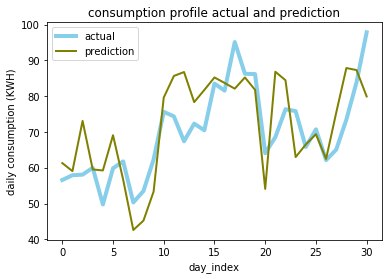

Error: 2.764
size of anomaly removed data:
(346, 12)


C:\Users\ruchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\ruchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


test dimension:
30
train dimension:
316
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   41.6s finished


Best parameters {'max_depth': 21, 'min_child_weight': 5}
Best score -239.981251907
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   16.1s finished


Best parameters {'max_depth': 20, 'min_child_weight': 4.5}
Best score -239.981251907
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    6.9s finished


Best parameters {'gamma': 0.9}
Best score -239.515724691
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   30.0s finished


Best parameters {'colsample_bytree': 1.0, 'subsample': 0.8}
Best score -207.668763812
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.2s finished


Best parameters {'subsample': 0.8}
Best score -207.668763812
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   31.2s finished


Best parameters {'reg_alpha': 0, 'reg_lambda': 0}
Best score -207.668763812
[0]	train-rmse:60.0546+0.216007	test-rmse:60.0488+0.895232
[1]	train-rmse:58.8751+0.19933	test-rmse:58.8789+0.902909
[2]	train-rmse:57.718+0.185545	test-rmse:57.7278+0.891
[3]	train-rmse:56.5829+0.181581	test-rmse:56.6139+0.876456
[4]	train-rmse:55.4745+0.178049	test-rmse:55.5238+0.861531
[5]	train-rmse:54.3819+0.182621	test-rmse:54.4499+0.841773
[6]	train-rmse:53.32+0.176723	test-rmse:53.3891+0.823337
[7]	train-rmse:52.2763+0.170285	test-rmse:52.3567+0.828442
[8]	train-rmse:51.2528+0.167363	test-rmse:51.3486+0.815889
[9]	train-rmse:50.2549+0.166789	test-rmse:50.3633+0.795818
[10]	train-rmse:49.2682+0.161045	test-rmse:49.3894+0.785857
[11]	train-rmse:48.3047+0.15536	test-rmse:48.438+0.778191
[12]	train-rmse:47.359+0.152022	test-rmse:47.5046+0.773988
[13]	train-rmse:46.4375+0.148124	test-rmse:46.5894+0.757862
[14]	train-rmse:45.5381+0.142509	test-rmse:45.7094+0.759729
[15]	train-rmse:44.6489+0.136707	test-rmse:4

[135]	train-rmse:5.89423+0.12705	test-rmse:10.3762+0.896863
[136]	train-rmse:5.82781+0.128552	test-rmse:10.3441+0.897749
[137]	train-rmse:5.76044+0.128346	test-rmse:10.3199+0.891297
[138]	train-rmse:5.69858+0.127601	test-rmse:10.2983+0.890298
[139]	train-rmse:5.63708+0.125862	test-rmse:10.2812+0.885612
[140]	train-rmse:5.57401+0.125401	test-rmse:10.2625+0.883319
[141]	train-rmse:5.51621+0.12543	test-rmse:10.2416+0.879876
[142]	train-rmse:5.45699+0.124965	test-rmse:10.2196+0.877541
[143]	train-rmse:5.4002+0.124574	test-rmse:10.2017+0.881193
[144]	train-rmse:5.34397+0.123126	test-rmse:10.1825+0.881651
[145]	train-rmse:5.28977+0.121902	test-rmse:10.1625+0.880105
[146]	train-rmse:5.23626+0.121577	test-rmse:10.1426+0.871792
[147]	train-rmse:5.1832+0.123098	test-rmse:10.1247+0.868567
[148]	train-rmse:5.13039+0.123241	test-rmse:10.1013+0.867739
[149]	train-rmse:5.0809+0.124269	test-rmse:10.0856+0.859355
[150]	train-rmse:5.03113+0.123802	test-rmse:10.0736+0.853117
[151]	train-rmse:4.98474+0.12

[75]	train-rmse:14.3116	eval-rmse:22.8456
[76]	train-rmse:14.0595	eval-rmse:22.4942
[77]	train-rmse:13.8262	eval-rmse:22.1801
[78]	train-rmse:13.5801	eval-rmse:21.8514
[79]	train-rmse:13.3419	eval-rmse:21.568
[80]	train-rmse:13.1111	eval-rmse:21.2864
[81]	train-rmse:12.8851	eval-rmse:20.972
[82]	train-rmse:12.66	eval-rmse:20.7078
[83]	train-rmse:12.4494	eval-rmse:20.4282
[84]	train-rmse:12.2431	eval-rmse:20.1441
[85]	train-rmse:12.0346	eval-rmse:19.8634
[86]	train-rmse:11.8278	eval-rmse:19.5947
[87]	train-rmse:11.6341	eval-rmse:19.3526
[88]	train-rmse:11.4407	eval-rmse:19.1014
[89]	train-rmse:11.2484	eval-rmse:18.8448
[90]	train-rmse:11.0648	eval-rmse:18.6202
[91]	train-rmse:10.8803	eval-rmse:18.3522
[92]	train-rmse:10.7073	eval-rmse:18.1599
[93]	train-rmse:10.5376	eval-rmse:17.9537
[94]	train-rmse:10.3709	eval-rmse:17.7493
[95]	train-rmse:10.2082	eval-rmse:17.5176
[96]	train-rmse:10.0475	eval-rmse:17.3107
[97]	train-rmse:9.88415	eval-rmse:17.1332
[98]	train-rmse:9.72741	eval-rmse:16.9

[268]	train-rmse:2.52751	eval-rmse:10.1916
[269]	train-rmse:2.51494	eval-rmse:10.1951
[270]	train-rmse:2.50429	eval-rmse:10.1931
[271]	train-rmse:2.4957	eval-rmse:10.1949
[272]	train-rmse:2.48727	eval-rmse:10.1906
[273]	train-rmse:2.47954	eval-rmse:10.1868
[274]	train-rmse:2.47345	eval-rmse:10.1809
[275]	train-rmse:2.46267	eval-rmse:10.1791
[276]	train-rmse:2.45406	eval-rmse:10.1812
[277]	train-rmse:2.44487	eval-rmse:10.1712
[278]	train-rmse:2.43417	eval-rmse:10.1698
[279]	train-rmse:2.42381	eval-rmse:10.1672
[280]	train-rmse:2.41369	eval-rmse:10.1632
[281]	train-rmse:2.40413	eval-rmse:10.1684
[282]	train-rmse:2.39859	eval-rmse:10.1641
[283]	train-rmse:2.38857	eval-rmse:10.1621
[284]	train-rmse:2.37752	eval-rmse:10.1607
[285]	train-rmse:2.36848	eval-rmse:10.1636
[286]	train-rmse:2.35962	eval-rmse:10.1675
[287]	train-rmse:2.35104	eval-rmse:10.1641
[288]	train-rmse:2.34322	eval-rmse:10.161
[289]	train-rmse:2.33278	eval-rmse:10.1565
[290]	train-rmse:2.32569	eval-rmse:10.1526
[291]	train-r

[460]	train-rmse:1.30211	eval-rmse:10.1927
[461]	train-rmse:1.29712	eval-rmse:10.1934
[462]	train-rmse:1.29351	eval-rmse:10.1911
[463]	train-rmse:1.28968	eval-rmse:10.1945
[464]	train-rmse:1.28642	eval-rmse:10.1949
[465]	train-rmse:1.28084	eval-rmse:10.197
[466]	train-rmse:1.27749	eval-rmse:10.1973
[467]	train-rmse:1.27157	eval-rmse:10.1958
[468]	train-rmse:1.26914	eval-rmse:10.1989
[469]	train-rmse:1.2656	eval-rmse:10.1974
[470]	train-rmse:1.26222	eval-rmse:10.1999
[471]	train-rmse:1.25819	eval-rmse:10.2016
[472]	train-rmse:1.25457	eval-rmse:10.1993
[473]	train-rmse:1.25069	eval-rmse:10.1964
[474]	train-rmse:1.24677	eval-rmse:10.1948
[475]	train-rmse:1.24372	eval-rmse:10.1922
[476]	train-rmse:1.23987	eval-rmse:10.1895
[477]	train-rmse:1.23696	eval-rmse:10.1895
[478]	train-rmse:1.23395	eval-rmse:10.1898
[479]	train-rmse:1.23008	eval-rmse:10.1885
[480]	train-rmse:1.22757	eval-rmse:10.1872
[481]	train-rmse:1.22534	eval-rmse:10.1887
[482]	train-rmse:1.22144	eval-rmse:10.1871
[483]	train-r

[650]	train-rmse:0.792404	eval-rmse:10.209
[651]	train-rmse:0.791092	eval-rmse:10.2097
[652]	train-rmse:0.789443	eval-rmse:10.2097
[653]	train-rmse:0.787711	eval-rmse:10.2076
[654]	train-rmse:0.786037	eval-rmse:10.2081
[655]	train-rmse:0.784779	eval-rmse:10.2068
[656]	train-rmse:0.783402	eval-rmse:10.2059
[657]	train-rmse:0.781958	eval-rmse:10.2061
[658]	train-rmse:0.780519	eval-rmse:10.207
[659]	train-rmse:0.778793	eval-rmse:10.2059
[660]	train-rmse:0.77635	eval-rmse:10.2059
[661]	train-rmse:0.774387	eval-rmse:10.2058
[662]	train-rmse:0.772773	eval-rmse:10.2071
[663]	train-rmse:0.771196	eval-rmse:10.2072
[664]	train-rmse:0.769128	eval-rmse:10.2076
[665]	train-rmse:0.767675	eval-rmse:10.2078
[666]	train-rmse:0.765919	eval-rmse:10.2077
[667]	train-rmse:0.764011	eval-rmse:10.2068
[668]	train-rmse:0.761485	eval-rmse:10.206
[669]	train-rmse:0.760002	eval-rmse:10.2069
[670]	train-rmse:0.758678	eval-rmse:10.2056
[671]	train-rmse:0.756182	eval-rmse:10.205
[672]	train-rmse:0.75421	eval-rmse:10

[838]	train-rmse:0.548685	eval-rmse:10.1879
[839]	train-rmse:0.548671	eval-rmse:10.1882
[840]	train-rmse:0.548046	eval-rmse:10.1887
[841]	train-rmse:0.547108	eval-rmse:10.1892
[842]	train-rmse:0.546259	eval-rmse:10.1891
[843]	train-rmse:0.545566	eval-rmse:10.1896
[844]	train-rmse:0.545167	eval-rmse:10.1897
[845]	train-rmse:0.544344	eval-rmse:10.1902
[846]	train-rmse:0.54302	eval-rmse:10.1894
[847]	train-rmse:0.542293	eval-rmse:10.1894
[848]	train-rmse:0.541241	eval-rmse:10.1895
[849]	train-rmse:0.540355	eval-rmse:10.1896
[850]	train-rmse:0.540235	eval-rmse:10.1895
[851]	train-rmse:0.53959	eval-rmse:10.1904
[852]	train-rmse:0.539115	eval-rmse:10.1905
[853]	train-rmse:0.538632	eval-rmse:10.1906
[854]	train-rmse:0.536883	eval-rmse:10.1898
[855]	train-rmse:0.536451	eval-rmse:10.1911
[856]	train-rmse:0.53517	eval-rmse:10.1912
[857]	train-rmse:0.534197	eval-rmse:10.1912
[858]	train-rmse:0.534115	eval-rmse:10.1912
[859]	train-rmse:0.533517	eval-rmse:10.1911
[860]	train-rmse:0.532327	eval-rmse

[1025]	train-rmse:0.456194	eval-rmse:10.189
[1026]	train-rmse:0.456031	eval-rmse:10.1891
[1027]	train-rmse:0.455915	eval-rmse:10.189
[1028]	train-rmse:0.455914	eval-rmse:10.1891
[1029]	train-rmse:0.45565	eval-rmse:10.1895
[1030]	train-rmse:0.455098	eval-rmse:10.1897
[1031]	train-rmse:0.455098	eval-rmse:10.1897
[1032]	train-rmse:0.454916	eval-rmse:10.19
[1033]	train-rmse:0.45431	eval-rmse:10.1895
[1034]	train-rmse:0.454188	eval-rmse:10.1895
[1035]	train-rmse:0.453964	eval-rmse:10.1891
[1036]	train-rmse:0.453441	eval-rmse:10.1893
[1037]	train-rmse:0.452459	eval-rmse:10.1898
[1038]	train-rmse:0.452173	eval-rmse:10.1895
[1039]	train-rmse:0.451659	eval-rmse:10.1885
[1040]	train-rmse:0.451476	eval-rmse:10.1884
[1041]	train-rmse:0.451104	eval-rmse:10.1892
[1042]	train-rmse:0.450922	eval-rmse:10.1892
[1043]	train-rmse:0.450576	eval-rmse:10.1891
[1044]	train-rmse:0.450239	eval-rmse:10.189
[1045]	train-rmse:0.450059	eval-rmse:10.189
[1046]	train-rmse:0.450058	eval-rmse:10.189
[1047]	train-rmse:0

[1208]	train-rmse:0.415768	eval-rmse:10.1868
[1209]	train-rmse:0.415746	eval-rmse:10.1871
[1210]	train-rmse:0.415673	eval-rmse:10.187
[1211]	train-rmse:0.415448	eval-rmse:10.187
[1212]	train-rmse:0.415448	eval-rmse:10.187
[1213]	train-rmse:0.415447	eval-rmse:10.1871
[1214]	train-rmse:0.415447	eval-rmse:10.1871
[1215]	train-rmse:0.415447	eval-rmse:10.1871
[1216]	train-rmse:0.415023	eval-rmse:10.1876
[1217]	train-rmse:0.414287	eval-rmse:10.1871
[1218]	train-rmse:0.413812	eval-rmse:10.1876
[1219]	train-rmse:0.413558	eval-rmse:10.1873
[1220]	train-rmse:0.413558	eval-rmse:10.1873
[1221]	train-rmse:0.413558	eval-rmse:10.1873
[1222]	train-rmse:0.413171	eval-rmse:10.1874
[1223]	train-rmse:0.41298	eval-rmse:10.1874
[1224]	train-rmse:0.41295	eval-rmse:10.1873
[1225]	train-rmse:0.41295	eval-rmse:10.1873
[1226]	train-rmse:0.412948	eval-rmse:10.1874
[1227]	train-rmse:0.412948	eval-rmse:10.1874
[1228]	train-rmse:0.412351	eval-rmse:10.1868
[1229]	train-rmse:0.412351	eval-rmse:10.1868
[1230]	train-rms

[1392]	train-rmse:0.396442	eval-rmse:10.1884
[1393]	train-rmse:0.396443	eval-rmse:10.1885
[1394]	train-rmse:0.396442	eval-rmse:10.1884
[1395]	train-rmse:0.396442	eval-rmse:10.1884
[1396]	train-rmse:0.396441	eval-rmse:10.1884
[1397]	train-rmse:0.396441	eval-rmse:10.1884
[1398]	train-rmse:0.39644	eval-rmse:10.1883
[1399]	train-rmse:0.396282	eval-rmse:10.188
[1400]	train-rmse:0.396282	eval-rmse:10.188
[1401]	train-rmse:0.396283	eval-rmse:10.1881
[1402]	train-rmse:0.396245	eval-rmse:10.188
[1403]	train-rmse:0.396245	eval-rmse:10.1881
[1404]	train-rmse:0.396245	eval-rmse:10.1881
[1405]	train-rmse:0.396245	eval-rmse:10.1881
[1406]	train-rmse:0.396253	eval-rmse:10.1887
[1407]	train-rmse:0.396252	eval-rmse:10.1886
[1408]	train-rmse:0.396252	eval-rmse:10.1886
[1409]	train-rmse:0.396157	eval-rmse:10.1882
[1410]	train-rmse:0.395886	eval-rmse:10.1882
[1411]	train-rmse:0.395693	eval-rmse:10.1882
[1412]	train-rmse:0.395693	eval-rmse:10.1882
[1413]	train-rmse:0.395693	eval-rmse:10.1882
[1414]	train-r

[1575]	train-rmse:0.386853	eval-rmse:10.1894
[1576]	train-rmse:0.386853	eval-rmse:10.1894
[1577]	train-rmse:0.386854	eval-rmse:10.1895
[1578]	train-rmse:0.386854	eval-rmse:10.1895
[1579]	train-rmse:0.386853	eval-rmse:10.1895
[1580]	train-rmse:0.386853	eval-rmse:10.1895
[1581]	train-rmse:0.386852	eval-rmse:10.1894
[1582]	train-rmse:0.386852	eval-rmse:10.1894
[1583]	train-rmse:0.386851	eval-rmse:10.1894
[1584]	train-rmse:0.386851	eval-rmse:10.1894
[1585]	train-rmse:0.386851	eval-rmse:10.1894
[1586]	train-rmse:0.386851	eval-rmse:10.1894
[1587]	train-rmse:0.386851	eval-rmse:10.1894
[1588]	train-rmse:0.386605	eval-rmse:10.1894
[1589]	train-rmse:0.386606	eval-rmse:10.1894
[1590]	train-rmse:0.386605	eval-rmse:10.1893
[1591]	train-rmse:0.386217	eval-rmse:10.1891
[1592]	train-rmse:0.386216	eval-rmse:10.1891
[1593]	train-rmse:0.386216	eval-rmse:10.189
[1594]	train-rmse:0.386217	eval-rmse:10.189
[1595]	train-rmse:0.386217	eval-rmse:10.189
[1596]	train-rmse:0.386217	eval-rmse:10.1889
[1597]	train-

[1759]	train-rmse:0.380015	eval-rmse:10.1903
[1760]	train-rmse:0.380015	eval-rmse:10.1903
[1761]	train-rmse:0.379915	eval-rmse:10.1903
[1762]	train-rmse:0.379915	eval-rmse:10.1902
[1763]	train-rmse:0.379915	eval-rmse:10.1902
[1764]	train-rmse:0.379914	eval-rmse:10.1902
[1765]	train-rmse:0.379915	eval-rmse:10.1902
[1766]	train-rmse:0.379915	eval-rmse:10.1902
[1767]	train-rmse:0.379914	eval-rmse:10.1902
[1768]	train-rmse:0.379914	eval-rmse:10.1902
[1769]	train-rmse:0.379914	eval-rmse:10.1903
[1770]	train-rmse:0.379914	eval-rmse:10.1902
[1771]	train-rmse:0.379914	eval-rmse:10.1902
[1772]	train-rmse:0.379914	eval-rmse:10.1902
[1773]	train-rmse:0.379915	eval-rmse:10.1902
[1774]	train-rmse:0.379914	eval-rmse:10.1902
[1775]	train-rmse:0.379914	eval-rmse:10.1902
[1776]	train-rmse:0.379915	eval-rmse:10.1902
[1777]	train-rmse:0.379915	eval-rmse:10.1902
[1778]	train-rmse:0.379401	eval-rmse:10.1898
[1779]	train-rmse:0.379401	eval-rmse:10.1898
[1780]	train-rmse:0.379402	eval-rmse:10.1898
[1781]	tra

[1942]	train-rmse:0.374002	eval-rmse:10.1905
[1943]	train-rmse:0.374002	eval-rmse:10.1905
[1944]	train-rmse:0.374003	eval-rmse:10.1905
[1945]	train-rmse:0.374003	eval-rmse:10.1905
[1946]	train-rmse:0.374001	eval-rmse:10.1906
[1947]	train-rmse:0.374002	eval-rmse:10.1906
[1948]	train-rmse:0.374001	eval-rmse:10.1906
[1949]	train-rmse:0.374	eval-rmse:10.1906
[1950]	train-rmse:0.373999	eval-rmse:10.1907
[1951]	train-rmse:0.373999	eval-rmse:10.1906
[1952]	train-rmse:0.373999	eval-rmse:10.1906
[1953]	train-rmse:0.373999	eval-rmse:10.1906
[1954]	train-rmse:0.373999	eval-rmse:10.1906
[1955]	train-rmse:0.373998	eval-rmse:10.1907
[1956]	train-rmse:0.373998	eval-rmse:10.1907
[1957]	train-rmse:0.373998	eval-rmse:10.1907
[1958]	train-rmse:0.373998	eval-rmse:10.1907
[1959]	train-rmse:0.373473	eval-rmse:10.1908
[1960]	train-rmse:0.373473	eval-rmse:10.1908
[1961]	train-rmse:0.373473	eval-rmse:10.1908
[1962]	train-rmse:0.373473	eval-rmse:10.1908
[1963]	train-rmse:0.373474	eval-rmse:10.1909
[1964]	train-

[2125]	train-rmse:0.368929	eval-rmse:10.1919
[2126]	train-rmse:0.368928	eval-rmse:10.1918
[2127]	train-rmse:0.368929	eval-rmse:10.1918
[2128]	train-rmse:0.36893	eval-rmse:10.1919
[2129]	train-rmse:0.368776	eval-rmse:10.1918
[2130]	train-rmse:0.368775	eval-rmse:10.1918
[2131]	train-rmse:0.368776	eval-rmse:10.1918
[2132]	train-rmse:0.368776	eval-rmse:10.1918
[2133]	train-rmse:0.368776	eval-rmse:10.1918
[2134]	train-rmse:0.368775	eval-rmse:10.1918
[2135]	train-rmse:0.368774	eval-rmse:10.1918
[2136]	train-rmse:0.368774	eval-rmse:10.1918
[2137]	train-rmse:0.368773	eval-rmse:10.1917
[2138]	train-rmse:0.368774	eval-rmse:10.1918
[2139]	train-rmse:0.368774	eval-rmse:10.1918
[2140]	train-rmse:0.368775	eval-rmse:10.1918
[2141]	train-rmse:0.368775	eval-rmse:10.1918
[2142]	train-rmse:0.368774	eval-rmse:10.1917
[2143]	train-rmse:0.368773	eval-rmse:10.1917
[2144]	train-rmse:0.368774	eval-rmse:10.1917
[2145]	train-rmse:0.368775	eval-rmse:10.1918
[2146]	train-rmse:0.368775	eval-rmse:10.1918
[2147]	trai

[2309]	train-rmse:0.366748	eval-rmse:10.1913
[2310]	train-rmse:0.366748	eval-rmse:10.1913
[2311]	train-rmse:0.366749	eval-rmse:10.1913
[2312]	train-rmse:0.366749	eval-rmse:10.1913
[2313]	train-rmse:0.366748	eval-rmse:10.1913
[2314]	train-rmse:0.366747	eval-rmse:10.1913
[2315]	train-rmse:0.366747	eval-rmse:10.1913
[2316]	train-rmse:0.366747	eval-rmse:10.1913
[2317]	train-rmse:0.366748	eval-rmse:10.1913
[2318]	train-rmse:0.366747	eval-rmse:10.1913
[2319]	train-rmse:0.366748	eval-rmse:10.1913
[2320]	train-rmse:0.366748	eval-rmse:10.1913
[2321]	train-rmse:0.366749	eval-rmse:10.1914
[2322]	train-rmse:0.366751	eval-rmse:10.1914
[2323]	train-rmse:0.366751	eval-rmse:10.1914
[2324]	train-rmse:0.36675	eval-rmse:10.1914
[2325]	train-rmse:0.366748	eval-rmse:10.1914
[2326]	train-rmse:0.366749	eval-rmse:10.1914
[2327]	train-rmse:0.366657	eval-rmse:10.191
[2328]	train-rmse:0.366656	eval-rmse:10.191
[2329]	train-rmse:0.366658	eval-rmse:10.191
[2330]	train-rmse:0.366655	eval-rmse:10.1909
[2331]	train-r

[2493]	train-rmse:0.363856	eval-rmse:10.1906
[2494]	train-rmse:0.363856	eval-rmse:10.1906
[2495]	train-rmse:0.363855	eval-rmse:10.1906
[2496]	train-rmse:0.363854	eval-rmse:10.1906
[2497]	train-rmse:0.363853	eval-rmse:10.1906
[2498]	train-rmse:0.363853	eval-rmse:10.1905
[2499]	train-rmse:0.363853	eval-rmse:10.1905
[2500]	train-rmse:0.363595	eval-rmse:10.1908
[2501]	train-rmse:0.363595	eval-rmse:10.1908
[2502]	train-rmse:0.363595	eval-rmse:10.1908
[2503]	train-rmse:0.363597	eval-rmse:10.1908
[2504]	train-rmse:0.363597	eval-rmse:10.1909
[2505]	train-rmse:0.363596	eval-rmse:10.1908
[2506]	train-rmse:0.363595	eval-rmse:10.1908
[2507]	train-rmse:0.363595	eval-rmse:10.1908
[2508]	train-rmse:0.363595	eval-rmse:10.1908
[2509]	train-rmse:0.363594	eval-rmse:10.1908
[2510]	train-rmse:0.363594	eval-rmse:10.1907
[2511]	train-rmse:0.363594	eval-rmse:10.1907
[2512]	train-rmse:0.363594	eval-rmse:10.1907
[2513]	train-rmse:0.363594	eval-rmse:10.1907
[2514]	train-rmse:0.363593	eval-rmse:10.1907
[2515]	tra

[2676]	train-rmse:0.361435	eval-rmse:10.1902
[2677]	train-rmse:0.361435	eval-rmse:10.1903
[2678]	train-rmse:0.361435	eval-rmse:10.1902
[2679]	train-rmse:0.361436	eval-rmse:10.1902
[2680]	train-rmse:0.361435	eval-rmse:10.1902
[2681]	train-rmse:0.361435	eval-rmse:10.1902
[2682]	train-rmse:0.361435	eval-rmse:10.1902
[2683]	train-rmse:0.361436	eval-rmse:10.1903
[2684]	train-rmse:0.361437	eval-rmse:10.1903
[2685]	train-rmse:0.361437	eval-rmse:10.1903
[2686]	train-rmse:0.361437	eval-rmse:10.1904
[2687]	train-rmse:0.361436	eval-rmse:10.1903
[2688]	train-rmse:0.361436	eval-rmse:10.1903
[2689]	train-rmse:0.361436	eval-rmse:10.1903
[2690]	train-rmse:0.361436	eval-rmse:10.1903
[2691]	train-rmse:0.361435	eval-rmse:10.1902
[2692]	train-rmse:0.361435	eval-rmse:10.1902
[2693]	train-rmse:0.361435	eval-rmse:10.1902
[2694]	train-rmse:0.361435	eval-rmse:10.1902
[2695]	train-rmse:0.361435	eval-rmse:10.1902
[2696]	train-rmse:0.361435	eval-rmse:10.1902
[2697]	train-rmse:0.361435	eval-rmse:10.1902
[2698]	tra

[2860]	train-rmse:0.358938	eval-rmse:10.1913
[2861]	train-rmse:0.358938	eval-rmse:10.1913
[2862]	train-rmse:0.358938	eval-rmse:10.1913
[2863]	train-rmse:0.358939	eval-rmse:10.1912
[2864]	train-rmse:0.358574	eval-rmse:10.191
[2865]	train-rmse:0.358574	eval-rmse:10.191
[2866]	train-rmse:0.358574	eval-rmse:10.191
[2867]	train-rmse:0.358574	eval-rmse:10.191
[2868]	train-rmse:0.358575	eval-rmse:10.1909
[2869]	train-rmse:0.358574	eval-rmse:10.1909
[2870]	train-rmse:0.358574	eval-rmse:10.1909
[2871]	train-rmse:0.358574	eval-rmse:10.1909
[2872]	train-rmse:0.358575	eval-rmse:10.1909
[2873]	train-rmse:0.358574	eval-rmse:10.1909
[2874]	train-rmse:0.358576	eval-rmse:10.1908
[2875]	train-rmse:0.358575	eval-rmse:10.1909
[2876]	train-rmse:0.358574	eval-rmse:10.1909
[2877]	train-rmse:0.358575	eval-rmse:10.1909
[2878]	train-rmse:0.358574	eval-rmse:10.1909
[2879]	train-rmse:0.358574	eval-rmse:10.1909
[2880]	train-rmse:0.358573	eval-rmse:10.1909
[2881]	train-rmse:0.358573	eval-rmse:10.191
[2882]	train-rm

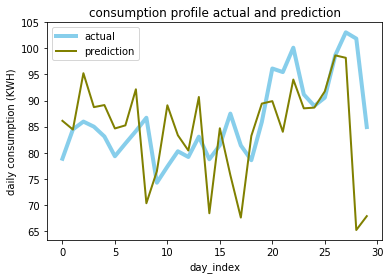

Error: 2.166
size of anomaly removed data:
(346, 12)


C:\Users\ruchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\ruchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


test dimension:
28
train dimension:
318
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   42.7s finished


Best parameters {'max_depth': 16, 'min_child_weight': 5}
Best score -241.586203646
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   14.8s finished


Best parameters {'max_depth': 15, 'min_child_weight': 4.5}
Best score -241.288013161
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    4.7s finished


Best parameters {'gamma': 0.7}
Best score -240.887084944
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   26.6s finished


Best parameters {'colsample_bytree': 1.0, 'subsample': 0.6}
Best score -221.130833445
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished


Best parameters {'subsample': 0.6}
Best score -221.130833445
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   28.8s finished


Best parameters {'reg_alpha': 0, 'reg_lambda': 0}
Best score -221.130833445
[0]	train-rmse:61.1972+0.405408	test-rmse:61.1947+1.59525
[1]	train-rmse:59.9952+0.401091	test-rmse:60.0008+1.55585
[2]	train-rmse:58.8213+0.387431	test-rmse:58.8397+1.5393
[3]	train-rmse:57.67+0.380446	test-rmse:57.7098+1.5114
[4]	train-rmse:56.5327+0.372628	test-rmse:56.5743+1.49359
[5]	train-rmse:55.421+0.366562	test-rmse:55.4708+1.46769
[6]	train-rmse:54.3356+0.359789	test-rmse:54.3865+1.44129
[7]	train-rmse:53.2809+0.354847	test-rmse:53.3462+1.42306
[8]	train-rmse:52.2345+0.353639	test-rmse:52.3109+1.40838
[9]	train-rmse:51.2111+0.341342	test-rmse:51.3067+1.38484
[10]	train-rmse:50.2051+0.332882	test-rmse:50.3102+1.39769
[11]	train-rmse:49.2318+0.326277	test-rmse:49.3454+1.38895
[12]	train-rmse:48.2658+0.318191	test-rmse:48.3945+1.37257
[13]	train-rmse:47.3331+0.31991	test-rmse:47.4896+1.35915
[14]	train-rmse:46.4233+0.313716	test-rmse:46.5861+1.37045
[15]	train-rmse:45.5115+0.299392	test-rmse:45.6805+1.36

[138]	train-rmse:6.51119+0.152712	test-rmse:10.296+0.991973
[139]	train-rmse:6.45287+0.15104	test-rmse:10.2674+0.99148
[140]	train-rmse:6.39791+0.149466	test-rmse:10.2454+0.995729
[141]	train-rmse:6.33931+0.148075	test-rmse:10.2171+0.985883
[142]	train-rmse:6.28363+0.151592	test-rmse:10.1888+0.988309
[143]	train-rmse:6.23176+0.151332	test-rmse:10.1698+0.98422
[144]	train-rmse:6.17947+0.152948	test-rmse:10.1492+0.988901
[145]	train-rmse:6.13013+0.154693	test-rmse:10.1304+0.990826
[146]	train-rmse:6.08301+0.153963	test-rmse:10.1103+0.994189
[147]	train-rmse:6.0349+0.150846	test-rmse:10.1024+0.994036
[148]	train-rmse:5.99536+0.147973	test-rmse:10.0884+0.994019
[149]	train-rmse:5.94907+0.14427	test-rmse:10.0735+0.997614
[150]	train-rmse:5.90687+0.141614	test-rmse:10.0621+0.99271
[151]	train-rmse:5.86465+0.143484	test-rmse:10.0516+0.996489
[152]	train-rmse:5.82274+0.145003	test-rmse:10.0379+0.993052
[153]	train-rmse:5.77955+0.14621	test-rmse:10.0195+0.99138
[154]	train-rmse:5.74048+0.147786

[59]	train-rmse:19.7791	eval-rmse:24.4693
[60]	train-rmse:19.4279	eval-rmse:24.0276
[61]	train-rmse:19.0713	eval-rmse:23.5261
[62]	train-rmse:18.7256	eval-rmse:23.1275
[63]	train-rmse:18.3949	eval-rmse:22.6915
[64]	train-rmse:18.0721	eval-rmse:22.3245
[65]	train-rmse:17.7564	eval-rmse:21.9645
[66]	train-rmse:17.4481	eval-rmse:21.6404
[67]	train-rmse:17.147	eval-rmse:21.2395
[68]	train-rmse:16.8538	eval-rmse:20.899
[69]	train-rmse:16.5574	eval-rmse:20.5509
[70]	train-rmse:16.27	eval-rmse:20.1894
[71]	train-rmse:15.9821	eval-rmse:19.8814
[72]	train-rmse:15.7145	eval-rmse:19.5871
[73]	train-rmse:15.45	eval-rmse:19.3083
[74]	train-rmse:15.1927	eval-rmse:19.0083
[75]	train-rmse:14.9294	eval-rmse:18.7331
[76]	train-rmse:14.6898	eval-rmse:18.4804
[77]	train-rmse:14.4423	eval-rmse:18.1907
[78]	train-rmse:14.2095	eval-rmse:17.9469
[79]	train-rmse:13.9774	eval-rmse:17.6554
[80]	train-rmse:13.7415	eval-rmse:17.3469
[81]	train-rmse:13.5235	eval-rmse:17.0687
[82]	train-rmse:13.3128	eval-rmse:16.832

[252]	train-rmse:3.74801	eval-rmse:9.62571
[253]	train-rmse:3.73719	eval-rmse:9.62439
[254]	train-rmse:3.72858	eval-rmse:9.63074
[255]	train-rmse:3.72034	eval-rmse:9.62353
[256]	train-rmse:3.70698	eval-rmse:9.62765
[257]	train-rmse:3.69458	eval-rmse:9.66509
[258]	train-rmse:3.68106	eval-rmse:9.6646
[259]	train-rmse:3.66801	eval-rmse:9.65464
[260]	train-rmse:3.659	eval-rmse:9.66413
[261]	train-rmse:3.64838	eval-rmse:9.66424
[262]	train-rmse:3.63474	eval-rmse:9.66339
[263]	train-rmse:3.62764	eval-rmse:9.65694
[264]	train-rmse:3.61494	eval-rmse:9.66199
[265]	train-rmse:3.60689	eval-rmse:9.66886
[266]	train-rmse:3.59662	eval-rmse:9.66793
[267]	train-rmse:3.5874	eval-rmse:9.66934
[268]	train-rmse:3.57762	eval-rmse:9.66851
[269]	train-rmse:3.56667	eval-rmse:9.68166
[270]	train-rmse:3.55683	eval-rmse:9.68841
[271]	train-rmse:3.54554	eval-rmse:9.68838
[272]	train-rmse:3.53782	eval-rmse:9.69201
[273]	train-rmse:3.52809	eval-rmse:9.69394
[274]	train-rmse:3.51796	eval-rmse:9.70001
[275]	train-rms

[444]	train-rmse:2.31047	eval-rmse:9.82314
[445]	train-rmse:2.30485	eval-rmse:9.82006
[446]	train-rmse:2.30057	eval-rmse:9.81503
[447]	train-rmse:2.29662	eval-rmse:9.81674
[448]	train-rmse:2.29225	eval-rmse:9.83145
[449]	train-rmse:2.28422	eval-rmse:9.83082
[450]	train-rmse:2.28099	eval-rmse:9.83341
[451]	train-rmse:2.27556	eval-rmse:9.83181
[452]	train-rmse:2.27054	eval-rmse:9.83391
[453]	train-rmse:2.26616	eval-rmse:9.83681
[454]	train-rmse:2.26199	eval-rmse:9.83611
[455]	train-rmse:2.25532	eval-rmse:9.83474
[456]	train-rmse:2.2496	eval-rmse:9.82932
[457]	train-rmse:2.24595	eval-rmse:9.82949
[458]	train-rmse:2.24237	eval-rmse:9.83519
[459]	train-rmse:2.23729	eval-rmse:9.83172
[460]	train-rmse:2.23054	eval-rmse:9.83659
[461]	train-rmse:2.22655	eval-rmse:9.84896
[462]	train-rmse:2.22251	eval-rmse:9.86598
[463]	train-rmse:2.21756	eval-rmse:9.86925
[464]	train-rmse:2.2121	eval-rmse:9.86653
[465]	train-rmse:2.206	eval-rmse:9.8698
[466]	train-rmse:2.20203	eval-rmse:9.87247
[467]	train-rmse

[636]	train-rmse:1.51657	eval-rmse:9.98394
[637]	train-rmse:1.51076	eval-rmse:9.9925
[638]	train-rmse:1.50916	eval-rmse:9.99175
[639]	train-rmse:1.50531	eval-rmse:9.99575
[640]	train-rmse:1.50398	eval-rmse:9.99306
[641]	train-rmse:1.50048	eval-rmse:9.99257
[642]	train-rmse:1.49645	eval-rmse:9.99024
[643]	train-rmse:1.49328	eval-rmse:9.99338
[644]	train-rmse:1.4892	eval-rmse:9.99765
[645]	train-rmse:1.48756	eval-rmse:9.99555
[646]	train-rmse:1.48546	eval-rmse:9.99519
[647]	train-rmse:1.48276	eval-rmse:9.99715
[648]	train-rmse:1.48089	eval-rmse:10
[649]	train-rmse:1.47804	eval-rmse:9.99948
[650]	train-rmse:1.47566	eval-rmse:9.99953
[651]	train-rmse:1.47231	eval-rmse:9.99108
[652]	train-rmse:1.46999	eval-rmse:9.99107
[653]	train-rmse:1.46679	eval-rmse:9.99157
[654]	train-rmse:1.46373	eval-rmse:9.99232
[655]	train-rmse:1.45964	eval-rmse:9.99362
[656]	train-rmse:1.45624	eval-rmse:10.0006
[657]	train-rmse:1.45303	eval-rmse:9.99991
[658]	train-rmse:1.4492	eval-rmse:9.99456
[659]	train-rmse:1.

[828]	train-rmse:1.03631	eval-rmse:10.1258
[829]	train-rmse:1.0345	eval-rmse:10.1304
[830]	train-rmse:1.03262	eval-rmse:10.1326
[831]	train-rmse:1.0309	eval-rmse:10.1311
[832]	train-rmse:1.02935	eval-rmse:10.1314
[833]	train-rmse:1.02765	eval-rmse:10.1353
[834]	train-rmse:1.02611	eval-rmse:10.1366
[835]	train-rmse:1.0242	eval-rmse:10.1348
[836]	train-rmse:1.02264	eval-rmse:10.1341
[837]	train-rmse:1.0215	eval-rmse:10.1408
[838]	train-rmse:1.02015	eval-rmse:10.1388
[839]	train-rmse:1.01815	eval-rmse:10.1393
[840]	train-rmse:1.01636	eval-rmse:10.1416
[841]	train-rmse:1.01485	eval-rmse:10.1432
[842]	train-rmse:1.01438	eval-rmse:10.1473
[843]	train-rmse:1.01258	eval-rmse:10.1488
[844]	train-rmse:1.01106	eval-rmse:10.1474
[845]	train-rmse:1.00946	eval-rmse:10.148
[846]	train-rmse:1.00791	eval-rmse:10.15
[847]	train-rmse:1.00558	eval-rmse:10.1539
[848]	train-rmse:1.00403	eval-rmse:10.1549
[849]	train-rmse:1.00282	eval-rmse:10.1542
[850]	train-rmse:1.00166	eval-rmse:10.1535
[851]	train-rmse:1

[1016]	train-rmse:0.756064	eval-rmse:10.2228
[1017]	train-rmse:0.754854	eval-rmse:10.2278
[1018]	train-rmse:0.753914	eval-rmse:10.2276
[1019]	train-rmse:0.753294	eval-rmse:10.2271
[1020]	train-rmse:0.751558	eval-rmse:10.2278
[1021]	train-rmse:0.750273	eval-rmse:10.227
[1022]	train-rmse:0.749139	eval-rmse:10.2268
[1023]	train-rmse:0.7481	eval-rmse:10.2305
[1024]	train-rmse:0.747126	eval-rmse:10.228
[1025]	train-rmse:0.745729	eval-rmse:10.2264
[1026]	train-rmse:0.744152	eval-rmse:10.2266
[1027]	train-rmse:0.741979	eval-rmse:10.2318
[1028]	train-rmse:0.741072	eval-rmse:10.2318
[1029]	train-rmse:0.740556	eval-rmse:10.2338
[1030]	train-rmse:0.738221	eval-rmse:10.2392
[1031]	train-rmse:0.736881	eval-rmse:10.2395
[1032]	train-rmse:0.735811	eval-rmse:10.2398
[1033]	train-rmse:0.734884	eval-rmse:10.2425
[1034]	train-rmse:0.733589	eval-rmse:10.2422
[1035]	train-rmse:0.732346	eval-rmse:10.2424
[1036]	train-rmse:0.731267	eval-rmse:10.2413
[1037]	train-rmse:0.730432	eval-rmse:10.2386
[1038]	train-r

[1200]	train-rmse:0.579715	eval-rmse:10.2819
[1201]	train-rmse:0.578851	eval-rmse:10.2826
[1202]	train-rmse:0.57805	eval-rmse:10.2826
[1203]	train-rmse:0.577561	eval-rmse:10.2831
[1204]	train-rmse:0.577053	eval-rmse:10.2826
[1205]	train-rmse:0.576394	eval-rmse:10.2833
[1206]	train-rmse:0.575507	eval-rmse:10.2824
[1207]	train-rmse:0.574591	eval-rmse:10.2825
[1208]	train-rmse:0.573684	eval-rmse:10.2811
[1209]	train-rmse:0.572842	eval-rmse:10.2801
[1210]	train-rmse:0.571939	eval-rmse:10.2795
[1211]	train-rmse:0.570877	eval-rmse:10.2789
[1212]	train-rmse:0.570315	eval-rmse:10.2782
[1213]	train-rmse:0.569513	eval-rmse:10.278
[1214]	train-rmse:0.568972	eval-rmse:10.2772
[1215]	train-rmse:0.568366	eval-rmse:10.276
[1216]	train-rmse:0.56776	eval-rmse:10.2752
[1217]	train-rmse:0.566808	eval-rmse:10.2757
[1218]	train-rmse:0.566454	eval-rmse:10.2761
[1219]	train-rmse:0.565696	eval-rmse:10.276
[1220]	train-rmse:0.564866	eval-rmse:10.2766
[1221]	train-rmse:0.564014	eval-rmse:10.2775
[1222]	train-rm

[1384]	train-rmse:0.472523	eval-rmse:10.3041
[1385]	train-rmse:0.472401	eval-rmse:10.3034
[1386]	train-rmse:0.471945	eval-rmse:10.3022
[1387]	train-rmse:0.471889	eval-rmse:10.3027
[1388]	train-rmse:0.471249	eval-rmse:10.3009
[1389]	train-rmse:0.470841	eval-rmse:10.2995
[1390]	train-rmse:0.470536	eval-rmse:10.3
[1391]	train-rmse:0.469397	eval-rmse:10.3003
[1392]	train-rmse:0.46888	eval-rmse:10.3019
[1393]	train-rmse:0.468589	eval-rmse:10.3037
[1394]	train-rmse:0.468384	eval-rmse:10.3027
[1395]	train-rmse:0.468214	eval-rmse:10.3031
[1396]	train-rmse:0.467876	eval-rmse:10.3036
[1397]	train-rmse:0.467315	eval-rmse:10.3018
[1398]	train-rmse:0.466551	eval-rmse:10.302
[1399]	train-rmse:0.466374	eval-rmse:10.3011
[1400]	train-rmse:0.466075	eval-rmse:10.3021
[1401]	train-rmse:0.465399	eval-rmse:10.303
[1402]	train-rmse:0.464658	eval-rmse:10.3033
[1403]	train-rmse:0.464698	eval-rmse:10.3033
[1404]	train-rmse:0.464211	eval-rmse:10.3046
[1405]	train-rmse:0.463587	eval-rmse:10.3058
[1406]	train-rms

[1567]	train-rmse:0.412369	eval-rmse:10.3328
[1568]	train-rmse:0.412348	eval-rmse:10.3328
[1569]	train-rmse:0.412252	eval-rmse:10.3329
[1570]	train-rmse:0.412053	eval-rmse:10.3328
[1571]	train-rmse:0.411906	eval-rmse:10.3328
[1572]	train-rmse:0.411787	eval-rmse:10.3327
[1573]	train-rmse:0.411786	eval-rmse:10.3327
[1574]	train-rmse:0.411496	eval-rmse:10.3321
[1575]	train-rmse:0.41131	eval-rmse:10.3321
[1576]	train-rmse:0.411157	eval-rmse:10.3321
[1577]	train-rmse:0.410585	eval-rmse:10.3339
[1578]	train-rmse:0.410479	eval-rmse:10.3337
[1579]	train-rmse:0.410044	eval-rmse:10.3337
[1580]	train-rmse:0.409646	eval-rmse:10.3344
[1581]	train-rmse:0.409291	eval-rmse:10.3345
[1582]	train-rmse:0.409157	eval-rmse:10.3345
[1583]	train-rmse:0.409156	eval-rmse:10.3345
[1584]	train-rmse:0.408823	eval-rmse:10.3343
[1585]	train-rmse:0.408212	eval-rmse:10.3343
[1586]	train-rmse:0.408003	eval-rmse:10.3343
[1587]	train-rmse:0.407642	eval-rmse:10.3357
[1588]	train-rmse:0.40745	eval-rmse:10.3369
[1589]	train

[1750]	train-rmse:0.382047	eval-rmse:10.3315
[1751]	train-rmse:0.382047	eval-rmse:10.3315
[1752]	train-rmse:0.382048	eval-rmse:10.3315
[1753]	train-rmse:0.381986	eval-rmse:10.3315
[1754]	train-rmse:0.381728	eval-rmse:10.3331
[1755]	train-rmse:0.381565	eval-rmse:10.3326
[1756]	train-rmse:0.381566	eval-rmse:10.3326
[1757]	train-rmse:0.381489	eval-rmse:10.3326
[1758]	train-rmse:0.381488	eval-rmse:10.3326
[1759]	train-rmse:0.381184	eval-rmse:10.3312
[1760]	train-rmse:0.380837	eval-rmse:10.3303
[1761]	train-rmse:0.380837	eval-rmse:10.3303
[1762]	train-rmse:0.380302	eval-rmse:10.3303
[1763]	train-rmse:0.380294	eval-rmse:10.3303
[1764]	train-rmse:0.380183	eval-rmse:10.3302
[1765]	train-rmse:0.380183	eval-rmse:10.3302
[1766]	train-rmse:0.380011	eval-rmse:10.3302
[1767]	train-rmse:0.379682	eval-rmse:10.3302
[1768]	train-rmse:0.379664	eval-rmse:10.3302
[1769]	train-rmse:0.379643	eval-rmse:10.3282
[1770]	train-rmse:0.379644	eval-rmse:10.3283
[1771]	train-rmse:0.379338	eval-rmse:10.328
[1772]	trai

[1933]	train-rmse:0.360897	eval-rmse:10.3369
[1934]	train-rmse:0.360898	eval-rmse:10.3369
[1935]	train-rmse:0.360897	eval-rmse:10.3369
[1936]	train-rmse:0.360897	eval-rmse:10.3369
[1937]	train-rmse:0.36069	eval-rmse:10.337
[1938]	train-rmse:0.360693	eval-rmse:10.337
[1939]	train-rmse:0.360693	eval-rmse:10.337
[1940]	train-rmse:0.360693	eval-rmse:10.337
[1941]	train-rmse:0.360692	eval-rmse:10.337
[1942]	train-rmse:0.360685	eval-rmse:10.337
[1943]	train-rmse:0.360685	eval-rmse:10.337
[1944]	train-rmse:0.360676	eval-rmse:10.3383
[1945]	train-rmse:0.360676	eval-rmse:10.3383
[1946]	train-rmse:0.360528	eval-rmse:10.3392
[1947]	train-rmse:0.360528	eval-rmse:10.3392
[1948]	train-rmse:0.360291	eval-rmse:10.3389
[1949]	train-rmse:0.36005	eval-rmse:10.339
[1950]	train-rmse:0.360024	eval-rmse:10.338
[1951]	train-rmse:0.359774	eval-rmse:10.3384
[1952]	train-rmse:0.359516	eval-rmse:10.3384
[1953]	train-rmse:0.359424	eval-rmse:10.3372
[1954]	train-rmse:0.359235	eval-rmse:10.3378
[1955]	train-rmse:0.3

[2117]	train-rmse:0.347502	eval-rmse:10.3462
[2118]	train-rmse:0.34736	eval-rmse:10.3458
[2119]	train-rmse:0.347102	eval-rmse:10.3445
[2120]	train-rmse:0.347029	eval-rmse:10.3445
[2121]	train-rmse:0.347028	eval-rmse:10.3445
[2122]	train-rmse:0.347029	eval-rmse:10.3445
[2123]	train-rmse:0.346962	eval-rmse:10.3438
[2124]	train-rmse:0.34663	eval-rmse:10.3438
[2125]	train-rmse:0.346397	eval-rmse:10.3437
[2126]	train-rmse:0.346399	eval-rmse:10.3437
[2127]	train-rmse:0.346397	eval-rmse:10.3438
[2128]	train-rmse:0.346309	eval-rmse:10.3437
[2129]	train-rmse:0.346324	eval-rmse:10.3434
[2130]	train-rmse:0.346143	eval-rmse:10.3444
[2131]	train-rmse:0.346143	eval-rmse:10.3444
[2132]	train-rmse:0.346144	eval-rmse:10.3444
[2133]	train-rmse:0.346143	eval-rmse:10.3444
[2134]	train-rmse:0.346144	eval-rmse:10.3444
[2135]	train-rmse:0.345719	eval-rmse:10.3457
[2136]	train-rmse:0.345719	eval-rmse:10.3457
[2137]	train-rmse:0.34572	eval-rmse:10.3457
[2138]	train-rmse:0.34572	eval-rmse:10.3457
[2139]	train-r

[2300]	train-rmse:0.339019	eval-rmse:10.3469
[2301]	train-rmse:0.339016	eval-rmse:10.3469
[2302]	train-rmse:0.339014	eval-rmse:10.347
[2303]	train-rmse:0.339016	eval-rmse:10.3469
[2304]	train-rmse:0.339019	eval-rmse:10.3469
[2305]	train-rmse:0.339022	eval-rmse:10.3469
[2306]	train-rmse:0.339019	eval-rmse:10.3469
[2307]	train-rmse:0.339018	eval-rmse:10.3469
[2308]	train-rmse:0.338744	eval-rmse:10.3469
[2309]	train-rmse:0.338743	eval-rmse:10.3469
[2310]	train-rmse:0.33874	eval-rmse:10.3469
[2311]	train-rmse:0.338741	eval-rmse:10.3469
[2312]	train-rmse:0.338668	eval-rmse:10.3465
[2313]	train-rmse:0.33867	eval-rmse:10.3465
[2314]	train-rmse:0.33867	eval-rmse:10.3465
[2315]	train-rmse:0.338501	eval-rmse:10.3466
[2316]	train-rmse:0.338436	eval-rmse:10.3484
[2317]	train-rmse:0.338436	eval-rmse:10.3484
[2318]	train-rmse:0.338437	eval-rmse:10.3484
[2319]	train-rmse:0.338436	eval-rmse:10.3484
[2320]	train-rmse:0.338436	eval-rmse:10.3484
[2321]	train-rmse:0.338436	eval-rmse:10.3484
[2322]	train-r

[2483]	train-rmse:0.334059	eval-rmse:10.3423
[2484]	train-rmse:0.33406	eval-rmse:10.3423
[2485]	train-rmse:0.333888	eval-rmse:10.3421
[2486]	train-rmse:0.333826	eval-rmse:10.3421
[2487]	train-rmse:0.333834	eval-rmse:10.3419
[2488]	train-rmse:0.333835	eval-rmse:10.3419
[2489]	train-rmse:0.333836	eval-rmse:10.3419
[2490]	train-rmse:0.333839	eval-rmse:10.342
[2491]	train-rmse:0.333839	eval-rmse:10.342
[2492]	train-rmse:0.333836	eval-rmse:10.3419
[2493]	train-rmse:0.333837	eval-rmse:10.3419
[2494]	train-rmse:0.333837	eval-rmse:10.3419
[2495]	train-rmse:0.333762	eval-rmse:10.3416
[2496]	train-rmse:0.333762	eval-rmse:10.3416
[2497]	train-rmse:0.333764	eval-rmse:10.3416
[2498]	train-rmse:0.333764	eval-rmse:10.3416
[2499]	train-rmse:0.333761	eval-rmse:10.3416
[2500]	train-rmse:0.333758	eval-rmse:10.3415
[2501]	train-rmse:0.333756	eval-rmse:10.3415
[2502]	train-rmse:0.333756	eval-rmse:10.3415
[2503]	train-rmse:0.333754	eval-rmse:10.3415
[2504]	train-rmse:0.333755	eval-rmse:10.3415
[2505]	train-

[2666]	train-rmse:0.328055	eval-rmse:10.342
[2667]	train-rmse:0.328008	eval-rmse:10.3421
[2668]	train-rmse:0.328008	eval-rmse:10.3422
[2669]	train-rmse:0.32801	eval-rmse:10.3422
[2670]	train-rmse:0.328013	eval-rmse:10.3422
[2671]	train-rmse:0.328015	eval-rmse:10.3422
[2672]	train-rmse:0.328016	eval-rmse:10.3422
[2673]	train-rmse:0.328014	eval-rmse:10.3422
[2674]	train-rmse:0.327715	eval-rmse:10.3425
[2675]	train-rmse:0.327717	eval-rmse:10.3425
[2676]	train-rmse:0.327721	eval-rmse:10.3425
[2677]	train-rmse:0.327722	eval-rmse:10.3425
[2678]	train-rmse:0.32772	eval-rmse:10.3425
[2679]	train-rmse:0.327653	eval-rmse:10.3425
[2680]	train-rmse:0.32766	eval-rmse:10.3426
[2681]	train-rmse:0.327662	eval-rmse:10.3426
[2682]	train-rmse:0.327661	eval-rmse:10.3426
[2683]	train-rmse:0.327658	eval-rmse:10.3426
[2684]	train-rmse:0.327393	eval-rmse:10.3421
[2685]	train-rmse:0.327391	eval-rmse:10.3421
[2686]	train-rmse:0.327397	eval-rmse:10.3421
[2687]	train-rmse:0.327398	eval-rmse:10.3421
[2688]	train-r

[2849]	train-rmse:0.324046	eval-rmse:10.3376
[2850]	train-rmse:0.324044	eval-rmse:10.3376
[2851]	train-rmse:0.324046	eval-rmse:10.3376
[2852]	train-rmse:0.324049	eval-rmse:10.3376
[2853]	train-rmse:0.324038	eval-rmse:10.3376
[2854]	train-rmse:0.324033	eval-rmse:10.3376
[2855]	train-rmse:0.324034	eval-rmse:10.3376
[2856]	train-rmse:0.324033	eval-rmse:10.3376
[2857]	train-rmse:0.324032	eval-rmse:10.3376
[2858]	train-rmse:0.324032	eval-rmse:10.3376
[2859]	train-rmse:0.324032	eval-rmse:10.3376
[2860]	train-rmse:0.324032	eval-rmse:10.3376
[2861]	train-rmse:0.324032	eval-rmse:10.3376
[2862]	train-rmse:0.324032	eval-rmse:10.3375
[2863]	train-rmse:0.324032	eval-rmse:10.3375
[2864]	train-rmse:0.324033	eval-rmse:10.3376
[2865]	train-rmse:0.324033	eval-rmse:10.3376
[2866]	train-rmse:0.323974	eval-rmse:10.3368
[2867]	train-rmse:0.323974	eval-rmse:10.3368
[2868]	train-rmse:0.323721	eval-rmse:10.3365
[2869]	train-rmse:0.323721	eval-rmse:10.3365
[2870]	train-rmse:0.3236	eval-rmse:10.3362
[2871]	train

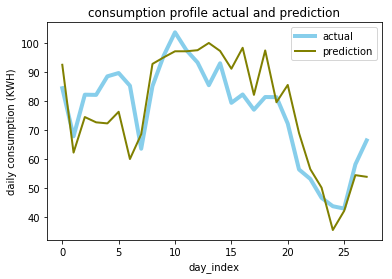

Error: 0.624


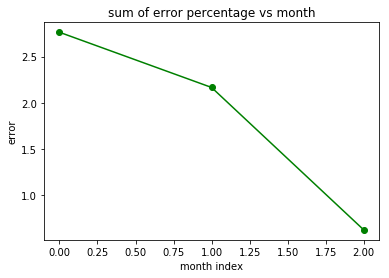

In [91]:
# testing the code part
my_dir= "C:/Users/ruchi/Desktop/WeatherData/"
month_name=['Jan','Feb','Mar','Apr','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
MONTH_TEST=['Jun','Jul','Aug']

filenames=get_filename_list(my_dir)
f=filenames[0]

acc=[]
for month in MONTH_TEST:
    accuracy=xgb_data(f,month)
    acc.append(accuracy)
    
file2=get_name(f)
plt.plot(acc,marker='o',color='g')
plt.ylabel('error')
plt.xlabel('month index')
plt.title('sum of error percentage vs month')
plt.savefig(file2)
plt.show()


In [ ]:
my_dir= "C:/Users/ruchi/Desktop/WeatherData/"
month_name=['Jan','Feb','Mar','Apr','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
filenames=get_filename_list(my_dir)
for f in filenames:
    acc=[]
    for month in month_name:
        accuracy=xgb_data(f,month)
        acc.append(accuracy)
    file2=get_name(f)
    plt.plot(acc,marker='o',color='g')
    plt.ylabel('error')
    plt.xlabel('month index')
    plt.title('sum of error percentage vs month')
    plt.savefig(file2)
    plt.show()
    
